# Investigating upward propagating lee wave behavior


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import ray_tracer as ray
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import xarray as xr
import gsw
import seaborn as sns
import cmocean
# %connect_info # shows kernel id for connecting an ipython console 
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp2d
from matplotlib import rcParams
plt.rcParams.update({'font.size':18})
rcParams['font.sans-serif'] = "Times New Roman"
rcParams['font.family'] = "sans-serif"
%connect_info


{
  "shell_port": 53406,
  "iopub_port": 53407,
  "stdin_port": 53408,
  "control_port": 53409,
  "hb_port": 53410,
  "ip": "127.0.0.1",
  "key": "8b498e89-8a26b079357eb10747b8233b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c30a14f8-f399-4128-b9fc-bb2a6a727a35.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
wave_properties = pd.read_pickle('CCW_dom_waves.pkl')
all_waves = pd.read_pickle('all_wave_props.pkl')
# load ray tracer and generate field functions using center field as mean of lat and long and depth
X = [wave_properties['lon'].mean(), wave_properties['lat'].mean(), 1000]
K = [wave_properties['k'].mean(), wave_properties['l'].mean(),
     wave_properties['m'].mean(), wave_properties['omega'].mean()]
t0 = wave_properties['date'].mean()

pad = 5
rt = ray.raytracer(X, K, t0, lonpad=pad, latpad=pad, tpad=21)
wave_properties

,k,l,m,omega,depth,lon,lat,date,p_prime,Rw,stn
0,0.000467,-0.000248,0.014842,-0.000228,2048.0,-49.474120,-53.761580,734558.0,0.021973,1.880952,1.0
1,0.000580,-0.000353,0.006249,-0.000359,1024.0,-49.465520,-53.758380,734558.0,0.015918,1.087331,2.0
2,0.000486,-0.000268,0.008202,-0.000322,2560.0,-49.236908,-53.562284,734559.0,0.028313,1.902460,6.0
3,0.000204,0.000032,0.008202,-0.000176,1024.0,-49.193775,-53.525682,734559.0,0.013254,0.935789,7.0
5,0.000344,0.000017,0.003125,-0.000415,512.0,-49.122354,-53.464639,734559.0,0.016821,0.900596,9.0
6,0.003658,0.001825,0.008202,-0.001458,3072.0,-49.080900,-53.421400,734559.0,0.035103,0.973536,10.0
7,0.001266,0.000195,0.008983,-0.000398,2560.0,-49.049306,-53.394546,734559.0,0.024673,1.618385,11.0
8,0.001966,-0.000515,0.025387,-0.000580,512.0,-48.999472,-53.332845,734559.0,0.011745,0.901281,13.0
9,0.000410,0.000360,0.010155,-0.000247,1536.0,-48.935919,-53.241273,734560.0,0.021963,0.935584,15.0
10,0.000287,-0.000087,0.006640,-0.000187,2048.0,-48.935919,-53.241273,734560.0,0.013667,1.302135,15.0


In [3]:
wave = wave_properties.loc[11]
wave.depth = 1024
wave.k = 0.00076
wave.l = -0.0003992948345679147

In [4]:
def transect(rtf, run, t0, depths=5000, plotevery=20):
    """
    Gets a depthwise transect along the run
    """
    depths = np.arange(50, depths, 50)
    
    data = []
    pv = plotevery

    tgrid = []
    for lon, lat, t1 in zip(run.Lon[::pv], run.Lat[::pv], run.time[::pv]):
        t = t0 + t1/60/60/24
#         print(lon)
        profile = []
        for d in depths:
#             print(d)
            xi = (lon, lat, d, t)
            profile.append(rtf(xi))
        
             
        profile = np.stack(profile)  
        data.append(profile)
    
    transect = [np.stack(data).T, run.time[::pv], depths]
    return transect


def transect_plots(run, wave1, rt, title=''):


    U = transect(rt.F.U, run, wave1.date, depths=5000, plotevery=50)
    V = transect(rt.F.V, run, wave1.date, depths=5000, plotevery=50)
    N2 = transect(rt.F.rho, run, wave1.date, depths=5000, plotevery=50)

    fig = plt.figure(figsize=(15,10))
    plt.subplot(221)
    pc1 = plt.pcolormesh(U[1]/60/60, -U[2], U[0], vmin=-.5, vmax=.5, cmap='seismic', shading='gouraud')

    cb1 = plt.colorbar(pc1, ticks=[-.5, 0, .5],  orientation="vertical", pad=0.15)
    cb1.set_label('m/s')
    levels = np.linspace(np.nanmin(U[0]), np.nanmax(U[0]), 20)
    pc11 = plt.contour(U[1]/60/60, -U[2][:-53], U[0][:-53,:], levels=levels,
                       colors = 'k', linestyles='solid', alpha=.2)

#     clabels = plt.clabel(pc11, pc11.levels[::3], inline=1, colors='k', fontsize=10)
#     [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

    plt.plot(run.time/60/60, -run.depth,label='wave 1', color='k', marker='+', markevery=100)

    b2 = np.full_like(run.bottom_depth, -10000)
    plt.fill_between(run.time/60/60, -run.bottom_depth, b2, color='k')
    plt.ylim(-4000, 0)
    plt.xlim(np.nanmin(N2[1])/60/60, np.nanmax(N2[1])/60/60)
    plt.xlabel('Hours')
    plt.title('U Velocity')

    #-----------------------------------------------------------------------------------------
    plt.subplot(223)
    pc1 = plt.pcolormesh(V[1]/60/60, -V[2], V[0], vmin = -.1, vmax=.1, cmap='seismic', shading='gouraud')

    cb1 = plt.colorbar(pc1, ticks=[-.1, 0, .1], orientation="vertical", pad=0.15)
    cb1.set_label('m/s')
#     cb1.set_ticklabels(['0.1'])
#     cbar = plt.colorbar(ticks=[1,2,3,4])
# cbar.set_ticklabels(['Winter', 'Pre Monsoon (Summer)', 'Monsoon', 'Post Monsoon'])
    levels = np.linspace(np.nanmin(V[0]), np.nanmax(V[0]), 20)
    pc11 = plt.contour(V[1]/60/60, -V[2][:-53], V[0][:-53,:], levels=levels,
                       colors = 'k', linestyles='solid', alpha=.2)

#     clabels = plt.clabel(pc11, pc11.levels[::3], inline=1, colors='k', fontsize=10)
#     [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

    plt.plot(run.time/60/60, -run.depth,label='wave 1', color='k', marker='+', markevery=100)

    b2 = np.full_like(run.bottom_depth, -10000)
    plt.fill_between(run.time/60/60, -run.bottom_depth, b2, color='k')
    plt.ylim(-4000, 0)
    plt.xlim(np.nanmin(N2[1])/60/60, np.nanmax(N2[1])/60/60)
    plt.xlabel('Hours')
    plt.title('V Velocity')

    #-----------------------------------------------------------------------------------------
    plt.subplot(122)
    pc2 = plt.pcolormesh(N2[1]/60/60, -N2[2], (N2[0]), cmap='plasma',shading='gouraud')


    cb2 = plt.colorbar(pc2, orientation="horizontal", pad=0.1)
    cb2.set_label(r'$kg / m^3 $')
    plt.plot(run.time/60/60, -run.depth,label='wave 1', color='k', marker='+', markevery=150)

    plt.fill_between(run.time/60/60, -run.bottom_depth, b2, color='k')

    levels = np.linspace(np.nanmin(N2[0]), np.nanmax(N2[0]), 20)
    pc22 = plt.contour(N2[1]/60/60, -N2[2][:-10], (N2[0][:-10,:]),colors = 'k', levels=levels, alpha=.5)
#     clabels = plt.clabel(pc22, pc22.levels[:-5:2], inline=1, colors='k', fontsize=10)
#     [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels[:-5]]

    plt.gca().get_yaxis().tick_right()
    plt.ylim(-4000, 0)
    plt.xlim(np.nanmin(N2[1])/60/60, np.nanmax(N2[1])/60/60)
    plt.xlabel('Hours')
    plt.title( '\n  ' + '\n  ' + r' Potential Density ($\sigma$)')

    plt.suptitle('Conditions along ray - TIME FORWARD ')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.savefig('along_ray.png', dpi=300, bbox_inches='tight')
    


    return fig


In [5]:
tstep = 600
# duration = 150
duration = 300
direction = 'forward'
# direction = 'reverse'

rt.K0 = [wave.k, wave.l, -wave.m, wave.omega]
rt.X0 = [wave.lon, wave.lat, wave.depth]
rt.t0 = wave.date
rt.p0 = wave.p_prime
full_wave = rt.run(tstep=tstep,
             duration=duration,
             direction=direction,
             strain=True,
             stops=True,
             clearance=.5,
             vertspeed=False,
             time_constant=False,
             progress_bar=True)

FloatProgress(value=0.0, max=1800.0)

In [6]:
no_strain = rt.run(tstep=tstep,
             duration=duration,
             direction=direction,
             shear = -.001,
             strain=False,
             stops=True,
             clearance=.5,
             vertspeed=False,
             time_constant=False,
             progress_bar=True)

FloatProgress(value=0.0, max=1800.0)

Hit Surface


In [7]:
t_constant = rt.run(tstep=tstep,
             duration=duration,
             direction=direction,
             shear = -.001,
             strain=True,
             stops=True,
             clearance=.5,
             vertspeed=False,
             time_constant=True,
             progress_bar=True)

FloatProgress(value=0.0, max=1800.0)

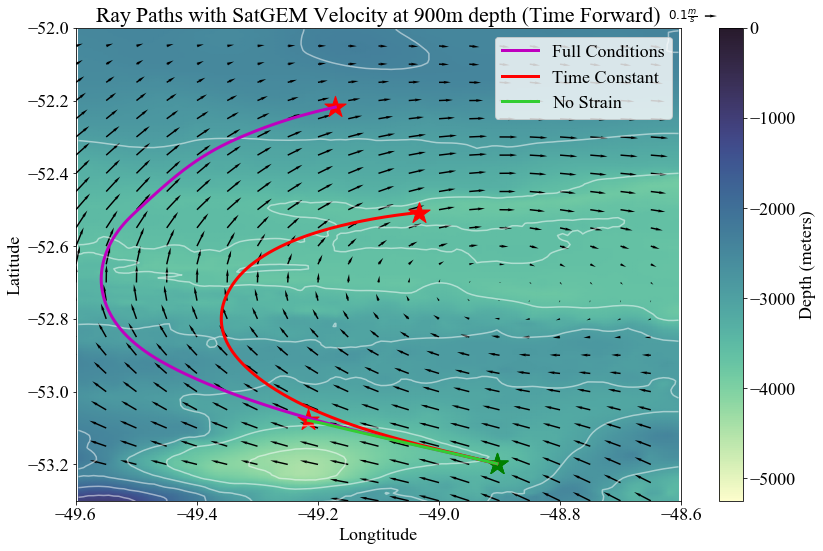

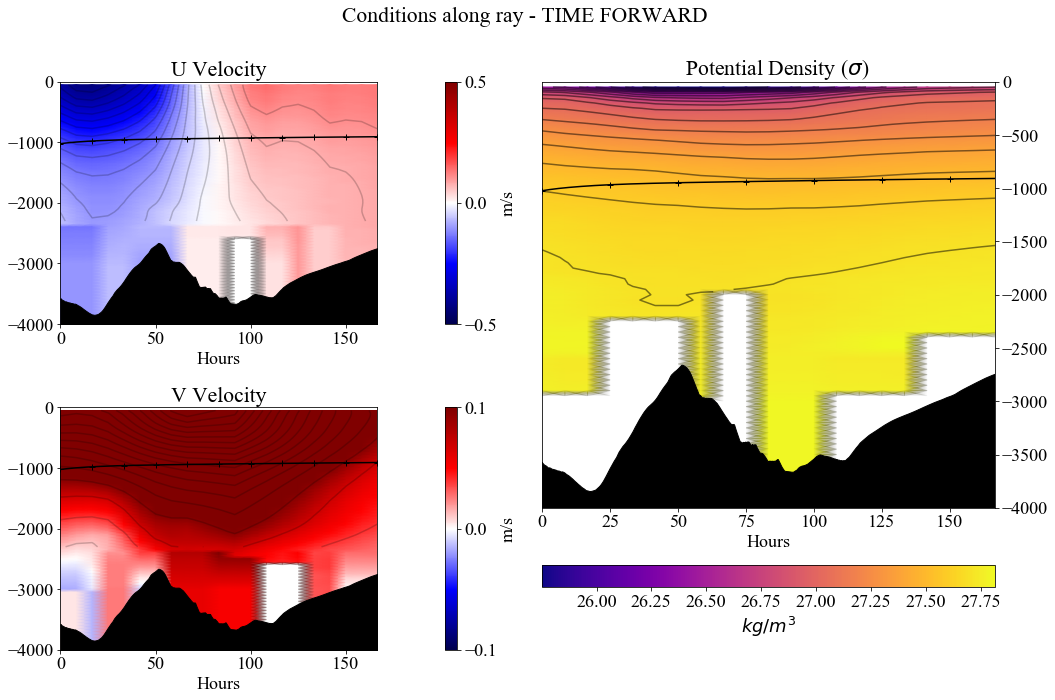

In [8]:
depth = 900
tmove = 5
# plt.style.use('seaborn-bright')
# ending = run.k.abs().argmin()
ending = np.argmin(np.abs(full_wave.time - 175*60*60))
ending2 = np.argmin(np.abs(full_wave.time - 130*60*60))

run1 = full_wave[:ending-10]
run2 = t_constant[:ending2-10]

xlim=slice(-49.6, -48.6)
ylim=slice(-53.3,-52)
depth2 = slice(depth, 6000)
lonlim = slice(-49.6, -48.6)
latlim = slice(-54,-52)
tind = rt.F.gem.time.sel(time=t0+tmove, method='nearest')
plt.figure(figsize=(10,10))


FU = interp2d(rt.F.gem.lon.sel(lon=lonlim),
              rt.F.gem.clat.sel(clat=latlim),
              rt.F.gem.U.sel(lon=lonlim, clat=latlim, depth=depth2, time=tind).mean(dim='depth').T)
FV = interp2d(rt.F.gem.clon.sel(clon=lonlim),
              rt.F.gem.lat.sel(lat=latlim),
              rt.F.gem.V.sel(clon=lonlim, lat=latlim, depth=depth2, time=tind).mean(dim='depth').T)

lonrevs = np.arange(lonlim.start, lonlim.stop, .05)
latrevs = np.arange(latlim.start, latlim.stop, .05)

Vrev = FV(lonrevs, latrevs)
Urev = FU(lonrevs, latrevs)
mappad = .2



# lonlim = slice(wave_properties['lon'].min(), wave_properties['lon'].max()+5*mappad)
# latlim = slice(wave_properties['lat'].min(), wave_properties['lat'].max()+2*mappad)
plt.figure(figsize=(12,8))

CS = plt.pcolormesh(rt.F.bathy_file.lon.sel(lon=lonlim),
            rt.F.bathy_file.lat.sel(lat=latlim),
            rt.F.bathy_file.elevation.sel(lon=lonlim, lat=latlim),
            shading='gouraud',
            vmax=0, cmap=cmocean.cm.deep)

cb1 = plt.colorbar(CS)
cb1.set_label('Depth (meters)')
CS = plt.contour(rt.F.bathy_file.lon.sel(lon=lonlim),
                rt.F.bathy_file.lat.sel(lat=latlim),
                rt.F.bathy_file.elevation.sel(lon=lonlim, lat=latlim), linestyles='solid',
                colors='white', alpha=.5)
# plt.clabel(CS, inline=4, fontsize=5,colors='white', backgroundcolor='white')


Q = plt.quiver(lonrevs, latrevs,
           Urev, Vrev, scale=5, headwidth=2, color='k')

qk = plt.quiverkey(Q, .83, .95, .1, r'$0.1 \frac{m}{s}$', labelpos='W',
                   labelcolor='k',
                   coordinates='figure',
                  fontproperties={'weight': 'bold','size':12})


ms = 500
step = 50
ii = 3
# plt.plot(run1.Lon, run1.Lat, 'white', lw =15, label='_nolegend_')
plt.plot(run1.Lon, run1.Lat, 'm', lw =3, label='Full Conditions')
plt.scatter(run1.Lon.values[0], run1.Lat.values[0], ms, 'g', marker='*')
plt.scatter(run1.Lon.values[-1], run1.Lat.values[-1], ms, 'r', marker='*')

plt.plot(run2.Lon, run2.Lat, 'red', lw =3, label='Time Constant')
plt.scatter(run2.Lon.values[0], run2.Lat.values[0], ms, 'g', marker='*')
plt.scatter(run2.Lon.values[-1], run2.Lat.values[-1], ms, 'r', marker='*')

plt.plot(no_strain.Lon, no_strain.Lat, 'limegreen', lw =3, label='No Strain')
plt.scatter(no_strain.Lon.values[0], no_strain.Lat.values[0], ms, 'g', marker='*')
plt.scatter(no_strain.Lon.values[-1], no_strain.Lat.values[-1], ms, 'r', marker='*')

# plt.quiver(run1.Lon[::step], run1.Lat[::step], run1.k[::step], run1.l[::step], scale=.01, color='m')
# plt.quiver(no_strain.Lon[::step], no_strain.Lat[::step],
#            no_strain.k[::step], no_strain.l[::step], scale=.01, color='m')

plt.gca().grid(False)



plt.title('Ray Paths with SatGEM Velocity at {}m depth (Time Forward)'.format(depth))
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.xlim(xlim.start, xlim.stop)
plt.ylim(ylim.start, ylim.stop)
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig('Time_forward.png',dpi=300, bbox_inches='tight')
figs = transect_plots(run1, wave, rt)


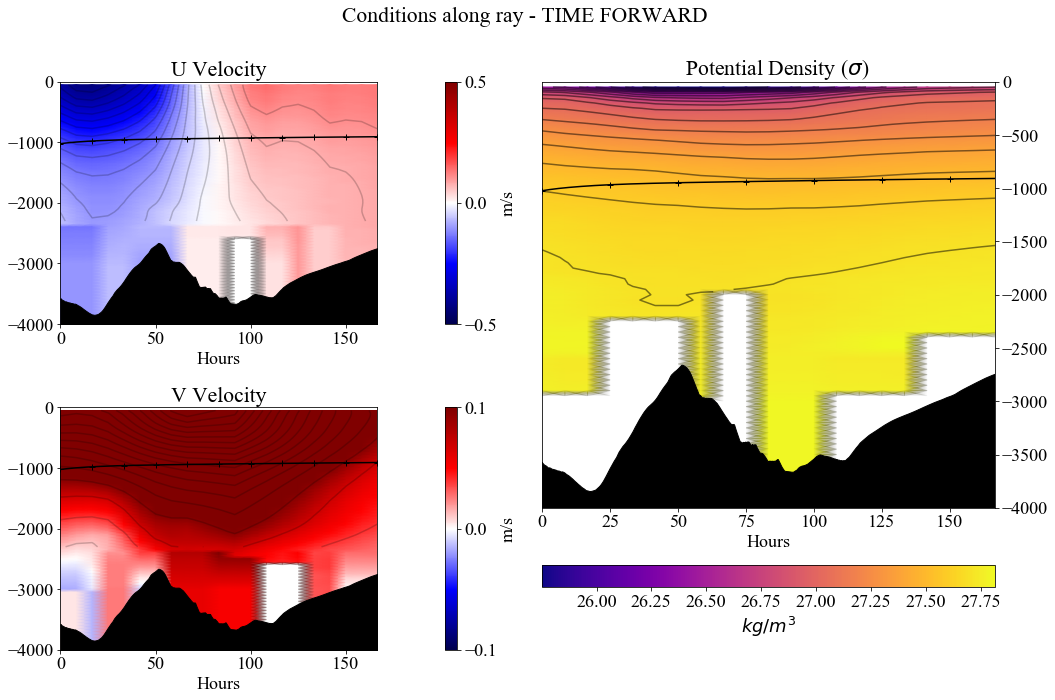

In [9]:
figs

1140


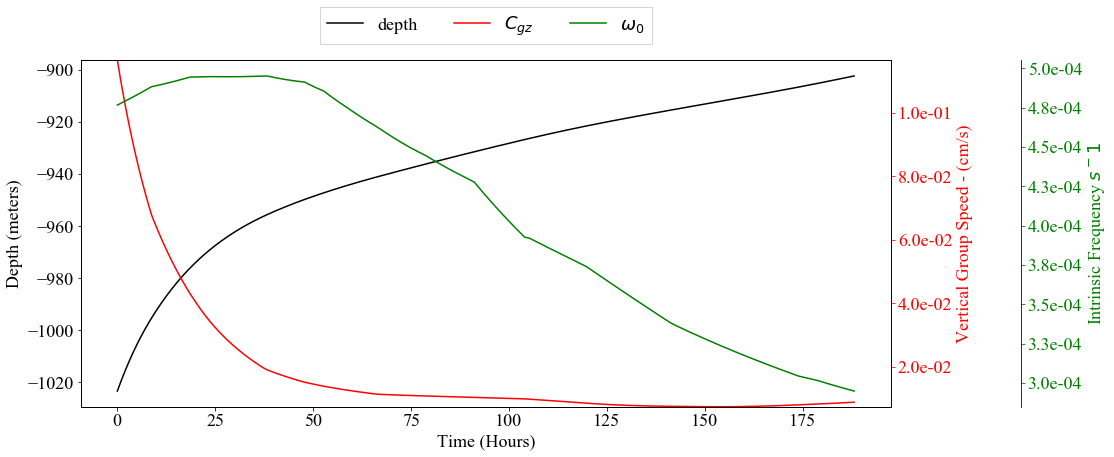

In [10]:
# Full Run
import matplotlib.ticker as mtick

# ending = run.k.abs().argmin()
ending = np.argmin(np.abs(full_wave.time - 190*60*60))
print(ending)
run1 = full_wave[:ending-10]
# run1 = t_constant[:ending-10]
run2 = no_strain[:]
f2 = (1e-4)**2
from matplotlib import rcParams
# plt.rcParams['axes.facecolor']='#F8F8F8'


plt.rcParams.update({'font.size':18})
rcParams['font.sans-serif'] = "Times New Roman"
rcParams['font.family'] = "sans-serif"


# show the vertical group speed approaching zero

fig, host = plt.subplots(figsize=(16,6))
K2 = run1.k**2 + run1.l**2 + run1.m**2
K2 = np.sqrt(K2)
l1 = plt.plot(run1.time/60/60, -run1.depth, 'k', label='depth')
plt.ylabel('Depth (meters)')
plt.xlabel('Time (Hours)')


# ax = plt.gca().twinx()
ax = host.twinx()
l2 = ax.plot(run1.time/60/60,run1.cgz*100,'r', label=r'$C_{gz}$')
ax.tick_params('y', colors='r')
plt.ylabel('Vertical Group Speed - (cm/s)', color='r')
# ax.spines['right'].set_position(('axes', 1.16))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# # ax1 = plt.gca().twinx()
# ax1 = host.twinx()
# l3 = ax1.plot(run1.time/60/60,run1.horiz_momentum,'b', label=r'$F_{m}^z$')
# ax1.tick_params('y', colors='b')
# plt.ylabel(r'Momentum flux - ($N/m^2$)', color='b')
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# ax1.spines['right'].set_position(('axes', 1.05))

ax2 = host.twinx()
l4 = ax2.plot(run1.time/60/60,np.abs(run1.omega),'g', label=r'$\omega_0$')
ax2.tick_params('y', colors='g')
plt.ylabel('Intrinsic Frequency $s^-1$', color='g')
ax2.spines['right'].set_position(('axes', 1.16))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

lns = l1 + l2 +l4
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.18),
          ncol=3, fancybox=False, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.set_ylim(run1.cgz.min()*100, run1.cgz.max()*100)
# ax1.set_ylim(run1.horiz_momentum.min(), run1.horiz_momentum.max())
host.grid(False)
ax.grid(False)
plt.tight_layout()
plt.savefig('runs1.png', dpi=300, bbox_inches='tight')

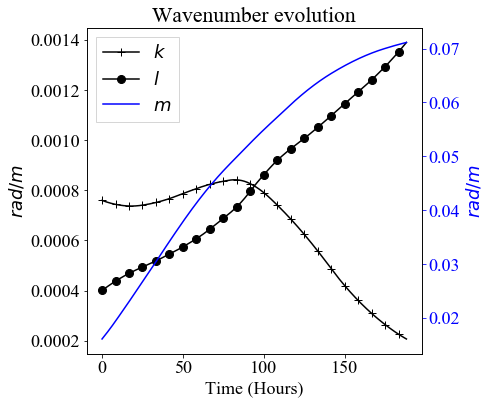

In [15]:
# ax1.grid(False)

vorticity = (run1.dvdx - run1.dudy)
strain_n = (run1.dudx - run1.dvdy)
strain_shear = (run1.dvdx + run1.dudy)
shear = run1.dudz**2 + run1.dvdz**2

okb = strain_n**2 + strain_shear**2 - vorticity**2
# plt.figure()
# plt.scatter(np.log10(run1.cgz), np.log10((run1.k**2 + run1.l**2+run1.m**2)**2), c='k')
# plt.rcParams.update({'font.size':12})
fig, host = plt.subplots(figsize=(6,6))
l1 = plt.plot(run1.time/60/60, np.abs(run1.k), 'k-+', markersize=8, markevery=50, label=r'$k$')

l2 = plt.plot(run1.time/60/60, np.abs(run1.l), 'k-o', markersize=8, markevery=50, label=r'$l$')
plt.xlabel('Time (Hours)')
plt.ylabel(r'$rad/m$')
           
ax = host.twinx()
l3 = ax.plot(run1.time/60/60,np.abs(run1.m),'b', label=r'$m$')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper left',
          ncol=1, fancybox=False, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.tick_params('y', colors='b')
plt.ylabel(r'$rad/m$', color='b')
plt.title('Wavenumber evolution')
# plt.grid() 
plt.savefig('wavenumbers.png', dpi=300, bbox_inches='tight')

Text(0.5,1,'$\\alpha$ ')

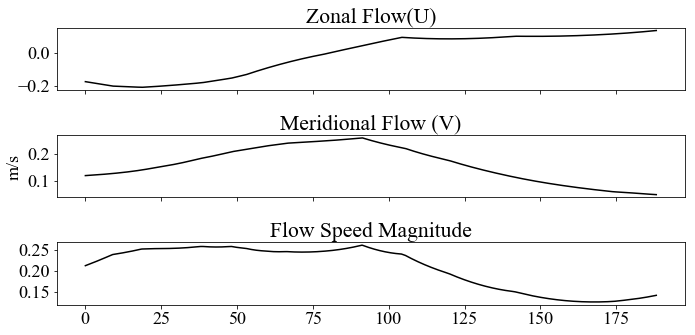

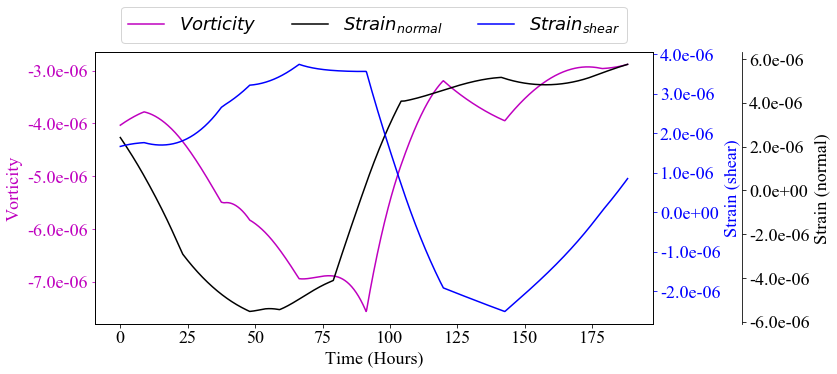

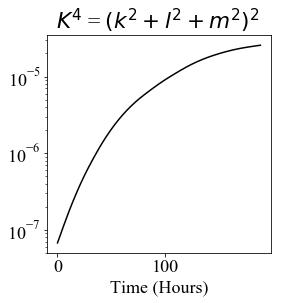

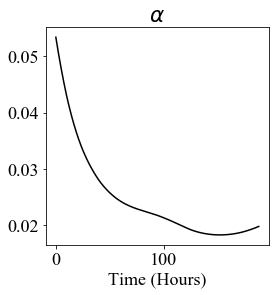

In [16]:
# ax.spines['right'].set_position(('axes', 1.108))



mag = np.sqrt(run1.U**2 + run1.V**2)
f, axx = plt.subplots(3,figsize=(10,5), sharex=True)

axx[0].plot(run1.time/60/60, run1.U, 'k')
axx[0].set_title('Zonal Flow(U)')

axx[1].set_ylabel('m/s')
axx[1].set_title('Meridional Flow (V)')

axx[1].plot(run1.time/60/60, run1.V, 'k')
# plt.title('Meridional Flow (V)')


axx[2].plot(run1.time/60/60, mag, 'k')
plt.title('Flow Speed Magnitude')
plt.tight_layout()


fig, host = plt.subplots(figsize=(10,5))


l1 = host.plot(run1.time/60/60, vorticity,'m', label=r'$Vorticity$')
host.tick_params('y', colors='m')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel(r'Vorticity', color='m')
plt.xlabel('Time (Hours)')

ax = host.twinx()
l2 = ax.plot(run1.time/60/60,strain_n,'k', label=r'$Strain_{normal}$')
ax.tick_params('y', colors='k')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (normal)', color='k')
ax.spines['right'].set_position(('axes', 1.16))
plt.xlabel('Time (Hours)')

ax2 = host.twinx()
l3 = ax2.plot(run1.time/60/60,strain_shear,'b', label=r'$Strain_{shear}$')
ax2.tick_params('y', colors='b')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (shear)', color='b')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('vorts.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(4,4))
plt.semilogy(run1.time/60/60, (run1.l**2 + run1.m**2+  run1.k**2)**2 , 'k')
plt.xlabel('Time (Hours)')
plt.title(r'$K^4$ = $(k^2 + l^2 + m^2)^2$ ')

plt.figure(figsize=(4,4))
plt.plot(run1.time/60/60, np.sqrt(run1.l**2 + run1.k**2) / np.abs(run1.m) , 'k')
# plt.scatter(run1.dvdz*10000, (run1.m))
plt.xlabel('Time (Hours)')
plt.title(r'$\alpha$ ')

KeyboardInterrupt: 

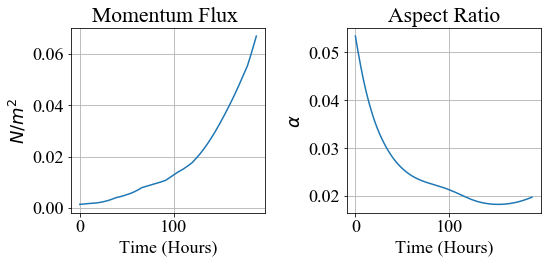

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(run1.time/60/60, run1.horiz_momentum)
plt.xlabel('Time (Hours)')
plt.ylabel(r'$N /m^2$')
plt.title(r'Momentum Flux ')
plt.grid()
# plt.subplot(132)
# plt.plot(run1.time/60/60, run1.energy)
# plt.xlabel('Time (Hours)')
# plt.ylabel(r'$J /m^3$')
# plt.title(r'Energy Density')
# plt.grid()
plt.subplot(122)
plt.plot(run1.time/60/60, np.sqrt(run1.l**2 + run1.k**2) / np.abs(run1.m))
plt.xlabel('Time (Hours)')
plt.ylabel(r'$\alpha$')
plt.title(r'Aspect Ratio')
plt.grid()
plt.tight_layout()
plt.savefig('mom_aspect.png', dpi=300, bbox_inches='tight')

figs = transect_plots(run1, wave, rt)

In [ ]:
import matplotlib.ticker as mtick
plt.style.use('seaborn-bright')
# ending = run.k.abs().argmin()
ending = np.argmin(np.abs(full_wave.time - 135*60*60))
print(ending)
# run1 = full_wave[:ending-10]
run1 = t_constant[:ending-10]
run2 = no_strain[:]
f2 = (1e-4)**2
from matplotlib import rcParams
# plt.rcParams['axes.facecolor']='#F8F8F8'



# show the vertical group speed approaching zero

fig, host = plt.subplots(figsize=(10,5))
K2 = run1.k**2 + run1.l**2 + run1.m**2
K2 = np.sqrt(K2)
l1 = plt.plot(run1.time/60/60, -run1.depth, 'k', label='depth')
plt.ylabel('Depth (meters)')
plt.xlabel('Time (Hours)')


# ax = plt.gca().twinx()
ax = host.twinx()
l2 = ax.plot(run1.time/60/60,run1.cgz*100,'r', label=r'$C_{gz}$')
ax.tick_params('y', colors='r')
plt.ylabel('Vertical Group Speed - (cm/s)', color='r')
# ax.spines['right'].set_position(('axes', 1.16))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# # ax1 = plt.gca().twinx()
# ax1 = host.twinx()
# l3 = ax1.plot(run1.time/60/60,run1.horiz_momentum,'b', label=r'$F_{m}^z$')
# ax1.tick_params('y', colors='b')
# plt.ylabel(r'Momentum flux - ($N/m^2$)', color='b')
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# ax1.spines['right'].set_position(('axes', 1.05))

ax2 = host.twinx()
l4 = ax2.plot(run1.time/60/60,np.abs(run1.omega),'g', label=r'$\omega_0$')
ax2.tick_params('y', colors='g')
plt.ylabel('Intrinsic Frequency $s^-1$', color='g')
ax2.spines['right'].set_position(('axes', 1.16))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

lns = l1 + l2 +l4
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.13),
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.set_ylim(run1.cgz.min()*100, run1.cgz.max()*100)
# ax1.set_ylim(run1.horiz_momentum.min(), run1.horiz_momentum.max())
host.grid(False)
ax.grid(False)
# ax1.grid(False)

vorticity = (run1.dvdx - run1.dudy)
strain_n = (run1.dudx - run1.dvdy)
strain_shear = (run1.dvdx + run1.dudy)


# plt.figure()
# plt.scatter(np.log10(run1.cgz), np.log10((run1.k**2 + run1.l**2+run1.m**2)**2), c='k')

fig, host = plt.subplots(figsize=(6,3))
l1 = plt.plot(run1.time/60/60, np.abs(run1.k), 'k-+', markersize=8, markevery=50, label=r'$k$')

l2 = plt.plot(run1.time/60/60, np.abs(run1.l), 'k-o', markersize=8, markevery=50, label=r'$l$')
plt.xlabel('Time (Hours)')
plt.ylabel(r'$m^{-1}$')
           
ax = host.twinx()
l3 = ax.plot(run1.time/60/60,np.abs(run1.m),'b', label=r'$m$')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center',
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.tick_params('y', colors='b')
plt.ylabel(r'$m^{-1}$', color='b')
plt.title('Time Constant Conditions: Wavenumber evolution')


# ax.spines['right'].set_position(('axes', 1.108))



mag = np.sqrt(run1.U**2 + run1.V**2)
f, axx = plt.subplots(3,figsize=(10,4), sharex=True)

axx[0].plot(run1.time/60/60, run1.U, 'k')
axx[0].set_title('Zonal Flow(U)')

axx[1].set_ylabel('m/s')
axx[1].set_title('Meridional Flow (V)')

axx[1].plot(run1.time/60/60, run1.V, 'k')
# plt.title('Meridional Flow (V)')


axx[2].plot(run1.time/60/60, mag, 'k')
plt.title('Flow Speed Magnitude')
plt.tight_layout()


fig, host = plt.subplots(figsize=(10,5))


l1 = host.plot(run1.time/60/60, vorticity,'m', label=r'$Vorticity$')
host.tick_params('y', colors='m')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel(r'Vorticity', color='m')
plt.xlabel('Time (Hours)')

ax = host.twinx()
l2 = ax.plot(run1.time/60/60,strain_n,'k', label=r'$Strain_{normal}$')
ax.tick_params('y', colors='k')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (normal)', color='k')
ax.spines['right'].set_position(('axes', 1.15))
plt.xlabel('Time (Hours)')

ax2 = host.twinx()
l3 = ax2.plot(run1.time/60/60,strain_shear,'b', label=r'$Strain_{shear}$')
ax2.tick_params('y', colors='b')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (shear)', color='b')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.figure(figsize=(4,4))
plt.semilogy(run1.time/60/60, (run1.l**2 + run1.m**2+  run1.k**2)**2 , 'k')
plt.xlabel('Time (Hours)')
plt.title(r'$K^4$ = $(k^2 + l^2 + m^2)^2$ ')

plt.figure(figsize=(4,4))
plt.plot(run1.time/60/60, np.sqrt(run1.l**2 + run1.k**2) / np.abs(run1.m) , 'k')
# plt.scatter(run1.dvdz*10000, (run1.m))
plt.xlabel('Time (Hours)')
plt.title(r'$\alpha$ ')

figs = transect_plots(run1, wave, rt)
plt.figure()
plt.plot(run1.time/60/60, run1.horiz_momentum)

1170


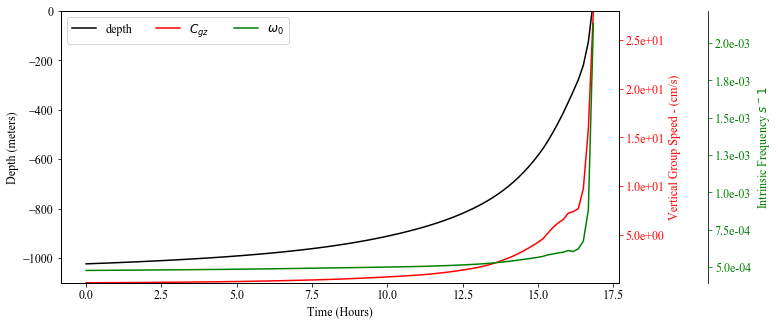

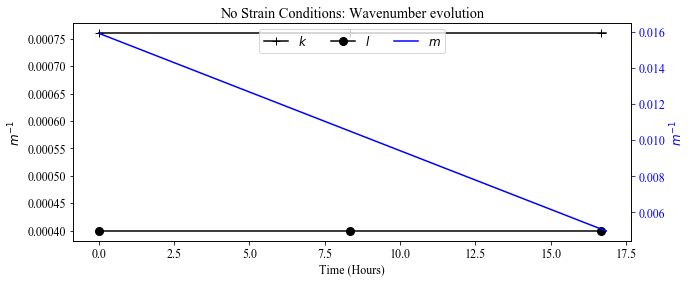

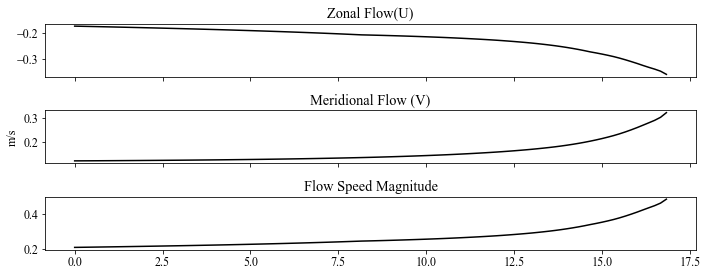

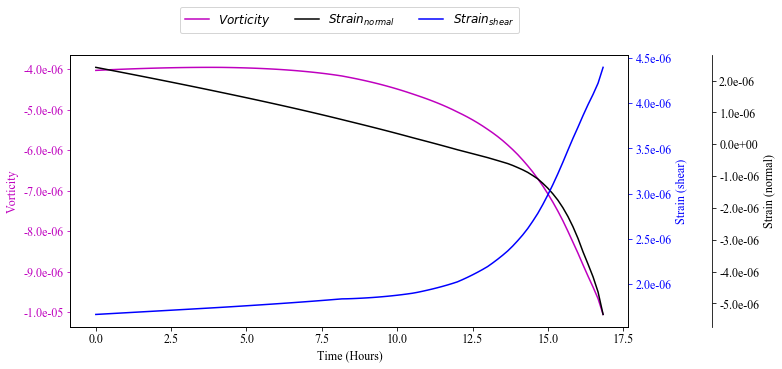

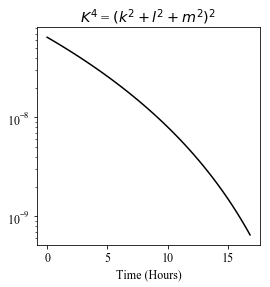

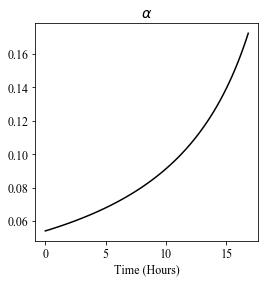

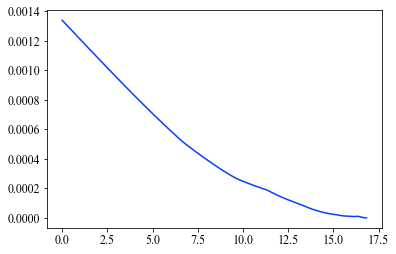

In [17]:
# locate wave ending point

import matplotlib.ticker as mtick
plt.style.use('seaborn-bright')
# ending = run.k.abs().argmin()
ending = np.argmin(np.abs(full_wave.time - 195*60*60))
print(ending)
# run1 = full_wave[:ending-10]
run1 = no_strain[:]
f2 = (1e-4)**2
from matplotlib import rcParams
# plt.rcParams['axes.facecolor']='#F8F8F8'


fig, host = plt.subplots(figsize=(10,5))
K2 = run1.k**2 + run1.l**2 + run1.m**2
K2 = np.sqrt(K2)
l1 = plt.plot(run1.time/60/60, -run1.depth, 'k', label='depth')
plt.ylim(-1100, 0)
plt.ylabel('Depth (meters)')
plt.xlabel('Time (Hours)')


# ax = plt.gca().twinx()
ax = host.twinx()
l2 = ax.plot(run1.time/60/60,run1.cgz*100,'r', label=r'$C_{gz}$')
ax.tick_params('y', colors='r')
plt.ylabel('Vertical Group Speed - (cm/s)', color='r')
# ax.spines['right'].set_position(('axes', 1.16))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# # ax1 = plt.gca().twinx()
# ax1 = host.twinx()
# l3 = ax1.plot(run1.time/60/60,run1.horiz_momentum,'b', label=r'$F_{m}^z$')
# ax1.tick_params('y', colors='b')
# plt.ylabel(r'Momentum flux - ($N/m^2$)', color='b')
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# ax1.spines['right'].set_position(('axes', 1.05))

ax2 = host.twinx()
l4 = ax2.plot(run1.time/60/60,np.abs(run1.omega),'g', label=r'$\omega_0$')
ax2.tick_params('y', colors='g')
plt.ylabel('Intrinsic Frequency $s^-1$', color='g')
ax2.spines['right'].set_position(('axes', 1.16))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

lns = l1 + l2 +l4
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='left center',
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.set_ylim(run1.cgz.min()*100, run1.cgz.max()*100)
# ax1.set_ylim(run1.horiz_momentum.min(), run1.horiz_momentum.max())
host.grid(False)
ax.grid(False)
# ax1.grid(False)

vorticity = (run1.dvdx - run1.dudy)
strain_n = (run1.dudx - run1.dvdy)
strain_shear = (run1.dvdx + run1.dudy)


# plt.figure()
# plt.scatter(np.log10(run1.cgz), np.log10((run1.k**2 + run1.l**2+run1.m**2)**2), c='k')
plt.rcParams.update({'font.size':12})
fig, host = plt.subplots(figsize=(10,4))
l1 = plt.plot(run1.time/60/60, np.abs(run1.k), 'k-+', markersize=8, markevery=50, label=r'$k$')

l2 = plt.plot(run1.time/60/60, np.abs(run1.l), 'k-o', markersize=8, markevery=50, label=r'$l$')
plt.xlabel('Time (Hours)')
plt.ylabel(r'$m^{-1}$')
           
ax = host.twinx()
l3 = ax.plot(run1.time/60/60,np.abs(run1.m),'b', label=r'$m$')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center',
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.tick_params('y', colors='b')
plt.ylabel(r'$m^{-1}$', color='b')
plt.title('No Strain Conditions: Wavenumber evolution')


# ax.spines['right'].set_position(('axes', 1.108))



mag = np.sqrt(run1.U**2 + run1.V**2)
f, axx = plt.subplots(3,figsize=(10,4), sharex=True)

axx[0].plot(run1.time/60/60, run1.U, 'k')
axx[0].set_title('Zonal Flow(U)')

axx[1].set_ylabel('m/s')
axx[1].set_title('Meridional Flow (V)')

axx[1].plot(run1.time/60/60, run1.V, 'k')
# plt.title('Meridional Flow (V)')


axx[2].plot(run1.time/60/60, mag, 'k')
plt.title('Flow Speed Magnitude')
plt.tight_layout()


fig, host = plt.subplots(figsize=(10,5))


l1 = host.plot(run1.time/60/60, vorticity,'m', label=r'$Vorticity$')
host.tick_params('y', colors='m')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel(r'Vorticity', color='m')
plt.xlabel('Time (Hours)')

ax = host.twinx()
l2 = ax.plot(run1.time/60/60,strain_n,'k', label=r'$Strain_{normal}$')
ax.tick_params('y', colors='k')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (normal)', color='k')
ax.spines['right'].set_position(('axes', 1.15))
plt.xlabel('Time (Hours)')

ax2 = host.twinx()
l3 = ax2.plot(run1.time/60/60,strain_shear,'b', label=r'$Strain_{shear}$')
ax2.tick_params('y', colors='b')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (shear)', color='b')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.figure(figsize=(4,4))
plt.semilogy(run1.time/60/60, (run1.l**2 + run1.m**2+  run1.k**2)**2 , 'k')
plt.xlabel('Time (Hours)')
plt.title(r'$K^4$ = $(k^2 + l^2 + m^2)^2$ ')

plt.figure(figsize=(4,4))
plt.plot(run1.time/60/60, np.sqrt(run1.l**2 + run1.k**2) / np.abs(run1.m) , 'k')
# plt.scatter(run1.dvdz*10000, (run1.m))
plt.xlabel('Time (Hours)')
plt.title(r'$\alpha$ ')


plt.figure()
plt.plot(run1.time/60/60, run1.horiz_momentum)

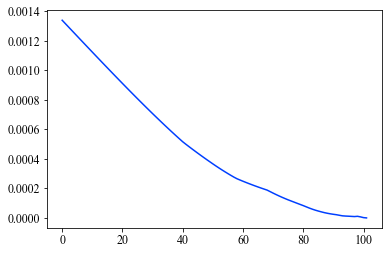

In [18]:
plt.plot(run1.horiz_momentum)

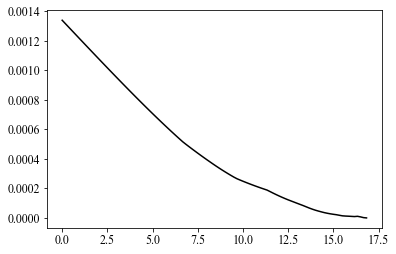

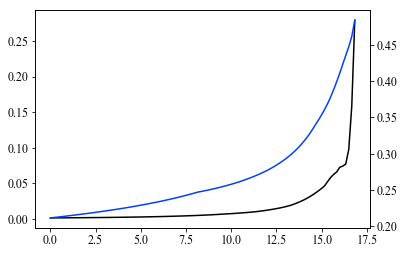

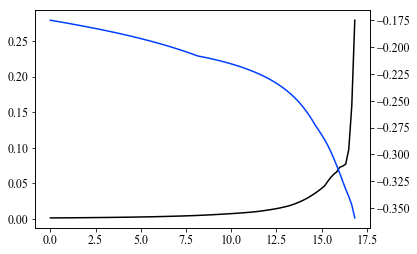

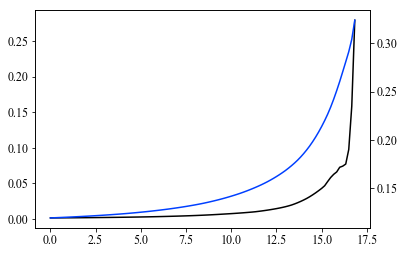

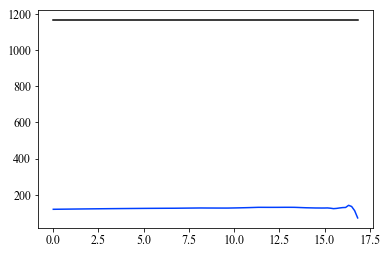

In [19]:

vorticity = (run1.dvdx - run1.dudy)
strain_n = (run1.dudx - run1.dvdy)
strain_shear = (run1.dvdx + run1.dudy)
strain = strain_n**2 + strain_shear**2
plt.figure()

mag = np.sqrt(run1.U**2 + run1.V**2)
plt.plot(run1.time/60/60, 
         run1.horiz_momentum, 'k')


plt.figure()

plt.plot(run1.time/60/60, run1.cgz, 'k')
ax2 = plt.gca().twinx()
ax2.plot(run1.time/60/60, mag)
# ax2.plot(run1.time/60/60, run1.m**2)

# ax2.plot(run1.time/60/60, strain, 'r')
# ax2.plot(run1.time/60/60, vorticity**2)
# ax2.plot(run1.time/60/60, run1.V)
# ax2.plot(run1.U, -run1.depth)

plt.figure()

plt.plot(run1.time/60/60, run1.cgz, 'k')
ax2 = plt.gca().twinx()
ax2.plot(run1.time/60/60, run1.U)


plt.figure()

plt.plot(run1.time/60/60, run1.cgz, 'k')
ax2 = plt.gca().twinx()
ax2.plot(run1.time/60/60, run1.V)

plt.figure()
Kh = run1.k**2 + run1.l**2 
Kh = np.sqrt(Kh)
plt.plot(run1.time/60/60, (mag/np.sqrt(run1.N2)))
plt.plot(run1.time/60/60,1/Kh,'k')



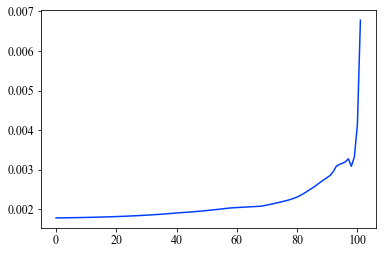

In [20]:
# Wave Parameter Panels


plt.plot(np.sqrt(run1.N2))

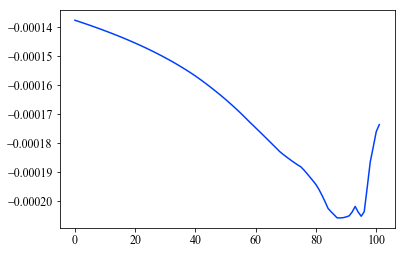

In [21]:
plt.plot((run1.dvdz))

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

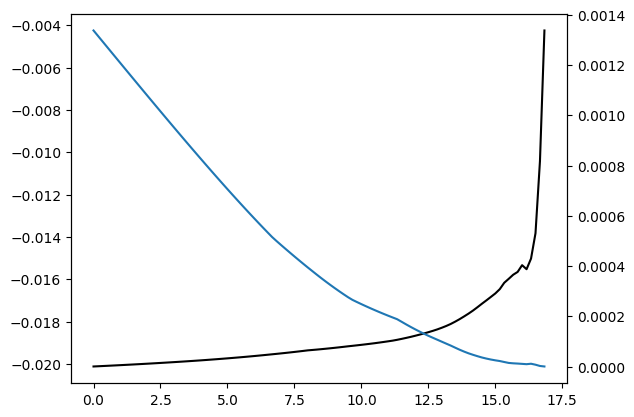

In [23]:
plt.figure()

mag = np.sqrt(run1.U**2 + run1.V**2)
plt.plot(run1.time/60/60, 
         run1.u0, 'k')
ax2 = plt.gca().twinx()
ax2.plot(run1.time/60/60, run1.horiz_momentum)


In [ ]:
plt.plot(run.m)

In [ ]:
plt.plot(run1.k)
e2 = np.argmin(np.abs(run.time - 130*60*60))
run.time[e2]/60/60

In [ ]:
plt.plot(run1.cgy)

In [ ]:
int(130*60*60)

In [ ]:
# locate wave ending point

import matplotlib.ticker as mtick
plt.style.use('seaborn-bright')
# ending = run.k.abs().argmin()
# ending = np.argmin(np.abs(full_wave.time - 195*60*60))
print(ending)
# run1 = full_wave[:ending-10]
ending = np.argmin(np.abs(full_wave.time - 140*60*60))
run1 = t_constant[:ending+50]
f2 = (1e-4)**2
from matplotlib import rcParams
# plt.rcParams['axes.facecolor']='#F8F8F8'


plt.rcParams.update({'font.size':12})


# show the vertical group speed approaching zero

fig, host = plt.subplots(figsize=(10,5))
K2 = run1.k**2 + run1.l**2 + run1.m**2
K2 = np.sqrt(K2)
l1 = plt.plot(run1.time/60/60, -run1.depth, 'k', label='depth')
plt.ylabel('Depth (meters)')
plt.xlabel('Time (Hours)')


# ax = plt.gca().twinx()
ax = host.twinx()
l2 = ax.plot(run1.time/60/60,run1.cgz*100,'r', label=r'$C_{gz}$')
ax.tick_params('y', colors='r')
plt.ylabel('Vertical Group Speed - (cm/s)', color='r')
# ax.spines['right'].set_position(('axes', 1.16))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# # ax1 = plt.gca().twinx()
# ax1 = host.twinx()
# l3 = ax1.plot(run1.time/60/60,run1.horiz_momentum,'b', label=r'$F_{m}^z$')
# ax1.tick_params('y', colors='b')
# plt.ylabel(r'Momentum flux - ($N/m^2$)', color='b')
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# ax1.spines['right'].set_position(('axes', 1.05))

ax2 = host.twinx()
l4 = ax2.plot(run1.time/60/60,np.abs(run1.omega),'g', label=r'$\omega_0$')
ax2.tick_params('y', colors='g')
plt.ylabel('Intrinsic Frequency $s^-1$', color='g')
ax2.spines['right'].set_position(('axes', 1.16))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

lns = l1 + l2 +l4
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.set_ylim(run1.cgz.min()*100, run1.cgz.max()*100)
# ax1.set_ylim(run1.horiz_momentum.min(), run1.horiz_momentum.max())
host.grid(False)
ax.grid(False)
# ax1.grid(False)

vorticity = (run1.dvdx - run1.dudy)
strain_n = (run1.dudx - run1.dvdy)
strain_shear = (run1.dvdx + run1.dudy)


# plt.figure()
# plt.scatter(np.log10(run1.cgz), np.log10((run1.k**2 + run1.l**2+run1.m**2)**2), c='k')
space = 500
plt.rcParams.update({'font.size':12})
fig, host = plt.subplots(figsize=(10,4))
l1 = plt.plot(run1.time/60/60, np.abs(run1.k), 'k-+', markersize=8, markevery=space, label=r'$k$')

l2 = plt.plot(run1.time/60/60, np.abs(run1.l), 'k-o', markersize=8, markevery=space, label=r'$l$')
plt.xlabel('Time (Hours)')
           
ax = host.twinx()
l3 = ax.plot(run1.time/60/60,np.abs(run1.m),'b', label=r'$m$')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center',
          ncol=2, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

ax.tick_params('y', colors='b')
plt.ylabel('Meters', color='b')
plt.title('Wavelengths')


# ax.spines['right'].set_position(('axes', 1.108))



mag = np.sqrt(run1.U**2 + run1.V**2)
f, axx = plt.subplots(3,figsize=(10,4), sharex=True)

axx[0].plot(run1.time/60/60, run1.U, 'k')
axx[0].set_title('Zonal Flow(U)')

axx[1].set_ylabel('m/s')
axx[1].set_title('Meridional Flow (V)')

axx[1].plot(run1.time/60/60, run1.V, 'k')
# plt.title('Meridional Flow (V)')


axx[2].plot(run1.time/60/60, mag, 'k')
plt.title('Flow Speed Magnitude')
plt.tight_layout()


fig, host = plt.subplots(figsize=(10,5))


l1 = host.plot(run1.time/60/60, vorticity,'m', label=r'$Vorticity$')
host.tick_params('y', colors='m')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel(r'Vorticity', color='m')
plt.xlabel('Time (Hours)')

ax = host.twinx()
l2 = ax.plot(run1.time/60/60,strain_n,'k', label=r'$Strain_{normal}$')
ax.tick_params('y', colors='k')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (normal)', color='k')
ax.spines['right'].set_position(('axes', 1.15))
plt.xlabel('Time (Hours)')

ax2 = host.twinx()
l3 = ax2.plot(run1.time/60/60,strain_shear,'b', label=r'$Strain_{shear}$')
ax2.tick_params('y', colors='b')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylabel('Strain (shear)', color='b')

lns = l1 + l2 +l3 
labs = [l.get_label() for l in lns]
legend = host.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=False)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.figure(figsize=(4,4))
plt.semilogy(run1.time/60/60, (run1.l**2 + run1.m**2+  run1.k**2)**2 , 'k')
plt.xlabel('Time (Hours)')
plt.title(r'$K^4$ = $(k^2 + l^2 + m^2)^2$ ')

plt.figure(figsize=(4,4))
plt.scatter(run1.dudz*10000, (run1.m))
plt.scatter(run1.dvdz*10000, (run1.m))
plt.xlabel('Time (Hours)')
plt.title(r'$K^4$ = $(k^2 + l^2 + m^2)^2$ ')


In [ ]:
rt.F.gem.time.diff('time').mean()

In [ ]:
2*np.pi/ np.sqrt(wave.k**2 + wave.l**2)

In [ ]:
depth = 900
tmove = 5
# plt.style.use('seaborn-bright')
# ending = run.k.abs().argmin()
ending = np.argmin(np.abs(full_wave.time - 175*60*60))
ending2 = np.argmin(np.abs(full_wave.time - 130*60*60))

run1 = full_wave[:ending-10]
run2 = t_constant[:ending2-10]

xlim=slice(-80, -40)
ylim=slice(-85,-52)
depth2 = slice(depth, 6000)
lonlim = slice(-80, -40)
latlim = slice(-85,-52)
tind = rt.F.gem.time.sel(time=t0+tmove, method='nearest')
plt.figure(figsize=(10,10))


FU = interp2d(rt.F.gem.lon.sel(lon=lonlim),
              rt.F.gem.clat.sel(clat=latlim),
              rt.F.gem.U.sel(lon=lonlim, clat=latlim, depth=depth2, time=tind).mean(dim='depth').T)
FV = interp2d(rt.F.gem.clon.sel(clon=lonlim),
              rt.F.gem.lat.sel(lat=latlim),
              rt.F.gem.V.sel(clon=lonlim, lat=latlim, depth=depth2, time=tind).mean(dim='depth').T)

lonrevs = np.arange(lonlim.start, lonlim.stop, .05)
latrevs = np.arange(latlim.start, latlim.stop, .05)

Vrev = FV(lonrevs, latrevs)
Urev = FU(lonrevs, latrevs)
mappad = .2



# lonlim = slice(wave_properties['lon'].min(), wave_properties['lon'].max()+5*mappad)
# latlim = slice(wave_properties['lat'].min(), wave_properties['lat'].max()+2*mappad)
plt.figure(figsize=(12,8))

CS = plt.pcolormesh(rt.F.bathy_file.lon.sel(lon=lonlim),
            rt.F.bathy_file.lat.sel(lat=latlim),
            rt.F.bathy_file.elevation.sel(lon=lonlim, lat=latlim),
            shading='gouraud',
            vmax=0, cmap=cmocean.cm.deep)

cb1 = plt.colorbar(CS)
cb1.set_label('Depth (meters)')
CS = plt.contour(rt.F.bathy_file.lon.sel(lon=lonlim),
                rt.F.bathy_file.lat.sel(lat=latlim),
                rt.F.bathy_file.elevation.sel(lon=lonlim, lat=latlim), linestyles='solid',
                colors='white', alpha=.5)
# plt.clabel(CS, inline=4, fontsize=5,colors='white', backgroundcolor='white')


Q = plt.quiver(lonrevs, latrevs,
           Urev, Vrev, scale=5, headwidth=2, color='k')

qk = plt.quiverkey(Q, .76, .97, .1, r'$0.1 \frac{m}{s}$', labelpos='W',
                   labelcolor='k',
                   coordinates='figure',
                  fontproperties={'weight': 'bold','size':12})


# ms = 500
# step = 50
# ii = 3
# # plt.plot(run1.Lon, run1.Lat, 'white', lw =15, label='_nolegend_')
# plt.plot(run1.Lon, run1.Lat, 'm', lw =3, label='Full Conditions')
# plt.scatter(run1.Lon.values[0], run1.Lat.values[0], ms, 'g', marker='*')
# plt.scatter(run1.Lon.values[-1], run1.Lat.values[-1], ms, 'r', marker='*')

# plt.plot(run2.Lon, run2.Lat, 'red', lw =3, label='Time Constant')
# plt.scatter(run2.Lon.values[0], run2.Lat.values[0], ms, 'g', marker='*')
# plt.scatter(run2.Lon.values[-1], run2.Lat.values[-1], ms, 'r', marker='*')

# plt.plot(no_strain.Lon, no_strain.Lat, 'limegreen', lw =3, label='No Strain')
# plt.scatter(no_strain.Lon.values[0], no_strain.Lat.values[0], ms, 'g', marker='*')
# plt.scatter(no_strain.Lon.values[-1], no_strain.Lat.values[-1], ms, 'r', marker='*')

# # plt.quiver(run1.Lon[::step], run1.Lat[::step], run1.k[::step], run1.l[::step], scale=.01, color='m')
# # plt.quiver(no_strain.Lon[::step], no_strain.Lat[::step],
# #            no_strain.k[::step], no_strain.l[::step], scale=.01, color='m')

plt.gca().grid(False)



plt.title('Ray Paths with SatGEM Velocity at {}m depth (Time Forward)'.format(depth))
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.xlim(xlim.start, xlim.stop)
plt.ylim(ylim.start, ylim.stop)
plt.legend(frameon=True)
plt.tight_layout()